<a href="https://colab.research.google.com/github/Forcer0625/RL/blob/main/EasyRL_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.1 定義DQN模型
直接利用torch的套件來建立全連接網路(Full-Connected Network)當作Q-Network

In [2]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, n_states, n_actions, hidden_dim=128):
    # 初始化Q-Net, 為FCN(or MLP), 這裡只有三層
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(n_states, hidden_dim) # 輸入層
    self.fc2 = nn.Linear(hidden_dim, hidden_dim) # 隱藏層
    self.fc3 = nn.Linear(hidden_dim, n_actions) # 輸出層
  
  def forward(self, x):
    # 定義各層的激勵函數(active function)，這裡全用relu
    x = nn.functional.relu(self.fc1(x))
    x = nn.functional.relu(self.fc2(x))
    return self.fc3(x)

# 1.2 定義Experience Replay
決定Experince Replay的buffer大小, 儲存一定量的transition時決策網路才會更新。
Experience Replay包含兩個比較重要的功能
###### 1.push: 將一個樣本放入buffer中, 滿了就將之前的丟掉, 可以用queue來實作
###### 2.sample: 定義如何採樣，採樣出一個或多個(依batch_size大小決定)

In [3]:
from collections import deque
import random

class ReplayBuffer(object):
  def __init__(self, capacity:int) -> None:
    self.capacity = capacity
    self.buffer = deque(maxlen=self.capacity)
  
  def push(self, transition):
    self.buffer.append(transition)
  
  def sample(self, batch_size:int, sequential:bool=False):
    # 如果batch size大於Experience Replay的容量大小，則直接取全部
    if batch_size > len(self.buffer):
      batch_size = len(self.buffer)
    # 循序採樣
    if sequential:
      # 從某個rand開始採樣batch_size個sample並回傳
      rand = random.randint(0, len(self.buffer)-batch_size)
      batch = [self.buffer[i] for i in range(rand, rand+batch_size)]
    else: # 隨機採樣
      batch = random.sample(self.buffer, batch_size)
    return zip(*batch)
  
  def clear(self):
    self.buffer.clear()
  
  def __len__(self):
    return len(self.buffer)

# 1.3 定義DDQN核心演算法

In [11]:
import torch
import torch.optim as optim
import math
import numpy as np

class DQN:
  def __init__(self, model, memory, cfg):
    self.n_actions = cfg['n_actions']  
    self.device = torch.device(cfg['device'])
    self.gamma = cfg['gamma'] # discounting factor
    # e-greedy策略相關參數
    self.sample_count = 0  # epsilon會隨時間衰退的count
    self.epsilon = cfg['epsilon_start']
    self.sample_count = 0  
    self.epsilon_start = cfg['epsilon_start']
    self.epsilon_end = cfg['epsilon_end']
    self.epsilon_decay = cfg['epsilon_decay']
    self.batch_size = cfg['batch_size']
    self.policy_net = model.to(self.device)
    self.target_net = model.to(self.device)
    # 複製一個通樣的網路到target Q-Net
    for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
        target_param.data.copy_(param.data)
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg['lr']) # 优化器
    self.memory = memory # 用於Experience Replay

  def sample_action(self, state):
    # 採樣動作
    self.sample_count += 1
    # epsilon指數遞減
    self.epsilon = self.epsilon_end+(self.epsilon_start-self.epsilon_end)*\
      math.exp(-1.0*self.sample_count/self.epsilon_decay)
    
    if random.random()>self.epsilon:
      with torch.no_grad():
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        # dueling DQN改這裡
        action = q_values.max(1)[1].item()
    else:
      action = random.randrange(self.n_actions)
    
    return action

  @torch.no_grad() #不計算gradient
  def predict_action(self, state):
    # 預測動作
    state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
    q_values = self.policy_net(state)
    # dueling DQN改這裡
    action = q_values.max(1)[1].item()
    return action
  
  def update(self):
    # 當buffer內的experience數量小於一個batch時,不更新網路
    if len(self.memory)<self.batch_size:
      return
    # 從Experience Replay中採樣
    state_batch,action_batch,reward_batch,next_state_batch,done_batch = self.memory.sample(self.batch_size)
    # 將採樣資料轉為tensor
    state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
    action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
    reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
    next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
    done_batch = torch.tensor(np.float32(done_batch), device=self.device)
    q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 計算目前狀態策略網路對應的q_value
    next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 計算目前狀態對應的target_q    
    expected_q_values = reward_batch+self.gamma*next_q_values*(1-done_batch) # 計算期望Q值, 若遇到終止狀態, 則對應的期望Q值等於reward
    loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1)) #計算 MSE loss
    # 選擇optimizer更新模型
    self.optimizer.zero_grad()
    loss.backward()
    # clip防止梯度爆炸
    for param in self.policy_net.parameters():
      param.grad.data.clamp_(-1,1)
    self.optimizer.step()

# 2. 定義訓練、測試函數

In [17]:
def train(cfg, env, agent):
  print("Start Training...")
  rewards = [] # 紀錄所有epside的reward
  steps = []
  for i_ep in range(cfg['train_eps']):
    ep_reward = 0 # 紀錄一個epside的reward
    state = env.reset() # 重製環境狀態
    ep_step = 0
    for _ in range(cfg['ep_max_steps']):
      ep_step += 1
      action = agent.sample_action(state) # 選擇動作
      next_state, reward, done, _ = env.step(action) # 更新環境
      agent.memory.push((state, action, reward, next_state, done))# 保留Experience
      state = next_state
      agent.update() # 更新決策網路
      ep_reward += reward # 累加reward
      if done:
        break
    # 一定回合數後將target Q-Net更新
    if (i_ep+1)%cfg['target_update']==0:
      agent.target_net.load_state_dict(agent.policy_net.state_dict())
    steps.append(ep_step)
    rewards.append(ep_reward)
    # 每10次訓練輸出訓練狀況
    if (i_ep+1)%10==0:
      print(f"回合：{i_ep+1}/{cfg['train_eps']}，獎勵：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
  print("Training Finished!")
  env.close()
  return {'rewards':rewards}

def test(cfg, env, agent):
  print("Start Testing...")
  rewards = []  # 紀錄所有epside的reward
  steps = []
  for i_ep in range(cfg['test_eps']):
    ep_reward = 0  # # 紀錄一個epside的reward
    state = env.reset() # 重製環境狀態
    ep_step = 0
    for _ in range(cfg['ep_max_steps']):
      ep_step+=1
      action = agent.predict_action(state)  # 選擇動作
      next_state, reward, done, _ = env.step(action)  # 更新環境
      state = next_state
      ep_reward += reward  # 累加reward
      if done:
          break
    steps.append(ep_step)
    rewards.append(ep_reward)
    print(f"回合：{i_ep+1}/{cfg['test_eps']}，獎勵：{ep_reward:.2f}")
  print("Testing Finished!")
  env.close()
  return {'rewards':rewards}

# 3. 定義環境

In [7]:
import gym
import os

def all_seed(env,seed = 1):
  env.seed(seed) # env config
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed) # config for CPU
  torch.cuda.manual_seed(seed) # config for GPU
  os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
  # config for cudnn
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.enabled = False

def env_agent_config(cfg):
  env = gym.make(cfg['env_name']) # 建立環境
  if cfg['seed'] !=0:
    all_seed(env,seed=cfg['seed'])
  n_states = env.observation_space.shape[0]
  n_actions = env.action_space.n
  print(f"狀態空間維度:{n_states}，動作空間維度:{n_actions}")
  cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg參數中
  model = MLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 建立模型
  memory = ReplayBuffer(cfg['memory_capacity'])
  agent = DQN(model,memory,cfg)
  return env,agent

# 4. 設定(超)參數

In [9]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

def get_args():
  # (超)參數設定
  parser = argparse.ArgumentParser(description="hyperparameters")      
  parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
  parser.add_argument('--env_name',default='CartPole-v0',type=str,help="name of environment")
  parser.add_argument('--train_eps',default=200,type=int,help="episodes of training")
  parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
  parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
  parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
  parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
  parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
  parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
  parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
  parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
  parser.add_argument('--batch_size',default=64,type=int)
  parser.add_argument('--target_update',default=4,type=int)
  parser.add_argument('--hidden_dim',default=256,type=int)
  parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") 
  parser.add_argument('--seed',default=10,type=int,help="seed")   
  args = parser.parse_args([])
  args = {**vars(args)}  
  ## 印出超参数
  print("超參數")
  print(''.join(['=']*80))
  tplt = "{:^20}\t{:^20}\t{:^20}"
  print(tplt.format("Name", "Value", "Type"))
  for k,v in args.items():
      print(tplt.format(k,v,str(type(v))))   
  print(''.join(['=']*80))      
  return args

def smooth(data, weight=0.9):  
  # 平滑曲線
  last = data[0] 
  smoothed = []
  for point in data:
    smoothed_val = last*weight+(1-weight)*point
    smoothed.append(smoothed_val)                    
    last = smoothed_val                                
  return smoothed

def plot_rewards(rewards,cfg, tag='train'):
  # 繪製reward變化圖
  sns.set()
  plt.figure()
  plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
  plt.xlabel('epsiodes')
  plt.plot(rewards, label='rewards')
  plt.plot(smooth(rewards), label='smoothed')
  plt.legend()
  plt.show()

# 5. DQN實戰訓練

超參數
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v0     	   <class 'str'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cpu         	   <class

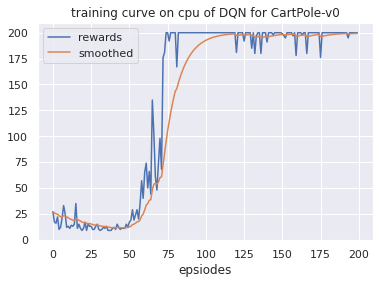

Start Testing...
回合：1/20，獎勵：200.00
回合：2/20，獎勵：182.00
回合：3/20，獎勵：200.00
回合：4/20，獎勵：200.00
回合：5/20，獎勵：200.00
回合：6/20，獎勵：200.00
回合：7/20，獎勵：194.00
回合：8/20，獎勵：183.00
回合：9/20，獎勵：200.00
回合：10/20，獎勵：200.00
回合：11/20，獎勵：200.00
回合：12/20，獎勵：200.00
回合：13/20，獎勵：192.00
回合：14/20，獎勵：200.00
回合：15/20，獎勵：200.00
回合：16/20，獎勵：181.00
回合：17/20，獎勵：182.00
回合：18/20，獎勵：200.00
回合：19/20，獎勵：184.00
回合：20/20，獎勵：187.00
Testing Finished!


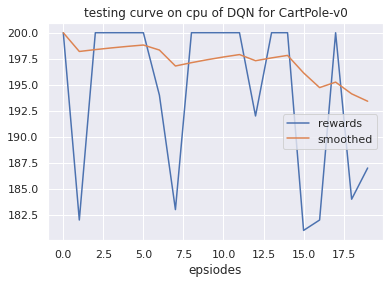

In [18]:
# 取得參數
cfg = get_args()
# 以DQN訓練
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)

plot_rewards(res_dic['rewards'], cfg, tag="train")

# 測試
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 畫出結果